# Project 4

## Problems Statement

### 1. Determine industry factors that can predict salary

### 2. Determine factors that distinguish job categories and title from each other

## Assumptions


#### Look at data-related jobs postings : data scientist, data analyst, business analyst, business intelligence, research scientist

#### Only limited to Singapore

In [1]:
from __future__ import division
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup
import re
import time
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import bokeh
import yellowbrick as yb
import networkx as nx

%matplotlib inline

### Get Software Versions

In [2]:
print ('Author - Lee Jiahe Steven')
print ('Date - 23 Oct 2017\n')
print ('Software versions... \n')
print ('numpy version : {}'.format(np.__version__))
print ('pandas version : {}'.format(pd.__version__))
print ('matplotlib version : {}'.format(matplotlib.__version__))
print ('seaborn version : {}'.format(sns.__version__))
print ('bokeh version : {}'.format(bokeh.__version__))
print ('yellowbrick version : {}'.format(yb.__version__))
print ('networkx version : {}'.format(nx.__version__))

Author - Lee Jiahe Steven
Date - 23 Oct 2017

Software versions... 

numpy version : 1.13.1
pandas version : 0.20.3
matplotlib version : 2.0.2
seaborn version : 0.8.0
bokeh version : 0.12.5
yellowbrick version : 0.5
networkx version : 1.11


In [646]:
import keras
print keras.__version__

2.0.5


### Global variable

In [4]:
USER_EMAIL = '' # Your email address with glassdoor account
PASSWORD = '' # Your glassdoor password
GMAP_API_KEY = '' # Your unique GMAP API key
LOCATION = 'SG'
SENIOR = r'sr|senior|master|vp'

In [5]:
EDUCATION = ['bachelor', 'master', 'phd', 'mba', 'diploma']

SKILLS = ['r', 'python', 'java', 'matlab', 'sql', 'nosql', 'hadoop', 'mapreduce', \
        'tableau', 'sas', 'spark',  'aws', 'mongodb', 'sap',\
         'pandas', 'sklearn', 'tensorflow', 'pytorch', 'deep', 'machine', 'linux']

JOBS = ['data-scientist', 'business-intelligence', 'data-analyst', 'data-engineer']

In [4]:
from selenium import webdriver
from selenium.webdriver.common import by
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.support.ui import WebDriverWait, Select
from selenium.webdriver.support import expected_conditions as EC

In [5]:
def init_glassdoor ():
    '''
    init_glassdoor - initialize selenium webdriver
    arg
        none
    return
        driver(webdriver)
    '''
    chrome_options = webdriver.ChromeOptions()

    driver = webdriver.Chrome('./chromedriver') # Direct this to the chromedriver you had downloaded

    driver.get("http://www.glassdoor.com/profile/login_input.htm")

    # Login page, key in user name and password
    user_field = WebDriverWait(driver, 10).until(EC.presence_of_element_located((by.By.NAME, 'username')))
    pw_field = driver.find_element_by_class_name('signin-password')
    login_button = driver.find_element_by_id('signInBtn')

    # Key in user name and password
    user_field.send_keys(USER_EMAIL)
    user_field.send_keys(Keys.TAB)
    pw_field.send_keys(PASSWORD)
    login_button.click()

    # At the index page, key in company name
    job_key = WebDriverWait(driver, 10).until(EC.presence_of_element_located((by.By.NAME, 'sc.keyword')))
    
    return driver

In [22]:
def get_glassdoor_info(driver, company):
    '''
    get_glassdoor_info - scrape information from glassdoor
    arg
        driver(webdriver) 
        company(string) 
    
    return
        dataframe
    '''
    time.sleep(1)
    # Select the dropdown menu to company, its default is job
    driver.find_element_by_xpath('//*[@id="SiteSrchTop"]/form/div').click() # Click dropdown to make it visible
    driver.find_element_by_xpath('//*[@id="SiteSrchTop"]/form/div/ul/li[2]').click() # Click company
    
    # Get company
    job_key = driver.find_element_by_id('sc.keyword')
    
    # Key in company name
    job_key.clear()
        
    job_key.send_keys(company)

    # Click button to continue
    driver.find_element_by_id('HeroSearchButton').click()

    try:
        # Set Timeout
        driver.set_page_load_timeout(5)
        
        # Select the first option (Brute force method..)
        driver.find_element_by_xpath('//*[@id="MainCol"]/div[1]/div[2]/div[1]/div[2]/div[1]/a').click()

        # Get year founded
        yr_founded = driver.find_element_by_xpath('//*[@id="EmpBasicInfo"]/div[1]/div/div[4]/span').text

        # Get size of company
        size_of_coy = driver.find_element_by_xpath('//*[@id="EmpBasicInfo"]/div[1]/div/div[3]/span').text

        # Get type of company 
        type_of_coy = driver.find_element_by_xpath('//*[@id="EmpBasicInfo"]/div[1]/div/div[5]/span').text

        # Get revenue of company
        rev_of_coy = driver.find_element_by_xpath('//*[@id="EmpBasicInfo"]/div[1]/div/div[7]/span').text

        # Go to salary page
        driver.find_element_by_xpath('//*[@id="EmpLinksWrapper"]/div/a[4]/span[2]').click()

        # Get all the salary with regular expression matching $..[k (optional)]
        salary = ','.join(re.findall('\$\d+.?',driver.find_element_by_xpath('//*[@id="SalaryChartContainer"]').text))
        
        vals = [yr_founded, size_of_coy, type_of_coy, rev_of_coy, salary]
        keys = ['Year_Founded', 'Company_Size', 'Company_Type', 'Company_Revenue', 'Company_Salary']
        
        print ('Glassdoor found : {}'.format(company))
        return pd.DataFrame(vals, index = keys, columns = [company])
    
    except:
        print ('Cant find the company at Glassdoor: {}'.format(company))

In [8]:
ignored_list = ['Career Advice to Find Better', 'Similar Jobs']


def get_job_df(job_name):
    '''
    get_job_df - based on the job name, scrape from monster and glassdoor and get the job information
    
    arg
        job_name (string)
    
    return
        dataframe
    '''
    jobs_df = pd.DataFrame()
    for i in range(1, 16):
        url = 'http://www.monster.com.sg/' + job_name + '-jobs-' + str(i) + '.html'
        response = requests.get(url)
        
        if response.status_code == 200:
            soup = BeautifulSoup(response.text, 'html.parser')
            for job in soup.find_all('span', attrs = {'class' : 'title_in'}):
                try:
                    job_title = job.text.strip()
                    job_company = job.find_next('span', attrs = {'itemprop' : 'hiringOrganization'}).text.strip()
                    job_skill = job.find_next('span', attrs = {'itemprop' : 'skills'}).text.strip()
                    job_exp = job.find_next('span', attrs = {'itemprop' : 'experienceRequirements'}).text.strip()
                    job_location = job.find_next('span', attrs = {'itemprop' : 'jobLocation'}).text.strip()

                    jobs_vals = [job_title, job_company, job_skill, job_exp, job_location]
                    jobs_keys = ['Title', 'Company', 'Skill', 'Experience', 'Location']

                    print ('Parsing..... {}'.format(job_company))

                    job_url = job.find_previous('a')['href']

                    if requests.get(job_url).status_code == 200:
                        soup_internal = BeautifulSoup(requests.get(job_url).text,'html.parser')
                        keys, vals = [], []

                        for i in soup_internal.find_all('div', attrs = {'class' : 'heading'}):
                            txt = i.text.strip()
                            if txt not in ignored_list:
                                if txt == 'Job Description':
                                    keys.append('Job_Description')
                                    vals.append(i.find_next('div', attrs = {'class' : 'desc'}).text.strip())
                                elif txt == 'Key Skill(s)':
                                    key_skills = []
                                    for j in i.find_next_siblings('div')[0].find_all('a'):
                                        key_skills.append(j.text)
                                    keys.append('Key_Skills')
                                    vals.append(' ,'.join(key_skills))
                                else:
                                    keys.append(txt)
                                    vals.append(i.find_next('span').text.strip())

                    else:
                        print ('Invalid URL ... {}'.format(re.sub('–','',BeautifulSoup(re.sub('–' , '' , str(job))).text)))

                    new_df = pd.DataFrame(jobs_vals, index = jobs_keys).append(pd.DataFrame(vals, index = keys))
                    jobs_df = pd.concat([jobs_df, new_df], axis = 1, ignore_index = True)
                    time.sleep(1)
                except:
                    print ('Error in parsing BeautifulSoup...')
                    continue
    return jobs_df

data_scientist_df = get_job_df(JOBS[0])

Parsing..... Charterhouse Pte Ltd
Parsing..... Singapore Telecommunications Ltd
Parsing..... Aspire Nxt Private Limited
Parsing..... Sciente International Pte Ltd
Parsing..... United Overseas Bank Limited
Parsing..... United Overseas Bank Limited
Parsing..... XPAND GROUP
Parsing..... ITCAN Pte Ltd
Parsing..... SearchElect Pte Ltd
Parsing..... SearchElect Pte Ltd
Parsing..... Allegis Group Singapore Pte Ltd
Parsing..... Singapore Telecommunications Ltd
Parsing..... Cavenagh Bridge Pte Ltd
Parsing..... GMP Technologies
Parsing..... PrimeStaff Management Services Pte Ltd
Parsing..... XPAND GROUP
Parsing..... PrimeStaff Management Services Pte Ltd
Parsing..... GMP Technologies
Parsing..... GMP Technologies
Parsing..... United Overseas Bank Limited
Parsing..... Kerry Consulting Pte Ltd
Parsing..... GMP Technologies
Parsing..... GMP Technologies
Parsing..... EarthStream Global Pte Ltd
Parsing..... Salt Search Pte Ltd
Parsing..... Optimum InfoSystem Private Limited
Parsing..... Kerry Consulti

Parsing..... Ambition Group Singapore Pte Ltd
Parsing..... Ambition Group Singapore Pte Ltd
Parsing..... New Step Search Pte Ltd
Parsing..... Capita Pte Ltd
Parsing..... Ambition Group Singapore Pte Ltd
Parsing..... Ambition Group Singapore Pte Ltd
Parsing..... Ambition Group Singapore Pte Ltd
Parsing..... Ambition Group Singapore Pte Ltd
Parsing..... Ambition Group Singapore Pte Ltd
Parsing..... Ambition Group Singapore Pte Ltd
Parsing..... Ambition Group Singapore Pte Ltd
Parsing..... Ambition Group Singapore Pte Ltd
Parsing..... Ambition Group Singapore Pte Ltd
Parsing..... Ambition Group Singapore Pte Ltd
Parsing..... Ambition Group Singapore Pte Ltd
Parsing..... Ambition Group Singapore Pte Ltd
Parsing..... Ambition Group Singapore Pte Ltd
Parsing..... Ambition Group Singapore Pte Ltd
Parsing..... Ambition Group Singapore Pte Ltd
Parsing..... Ambition Group Singapore Pte Ltd
Parsing..... Ambition Group Singapore Pte Ltd
Parsing..... Ambition Group Singapore Pte Ltd
Parsing..... Am

Error in parsing BeautifulSoup...
Parsing..... ITCAN Pte Ltd
Error in parsing BeautifulSoup...
Parsing..... Techknowledgey Pte Ltd
Error in parsing BeautifulSoup...
Parsing..... Techknowledgey Pte Ltd
Error in parsing BeautifulSoup...
Parsing..... Sciente International Pte Ltd
Error in parsing BeautifulSoup...
Parsing..... United Overseas Bank Limited
Error in parsing BeautifulSoup...
Parsing..... Capita Pte Ltd
Error in parsing BeautifulSoup...
Parsing..... Capita Pte Ltd
Error in parsing BeautifulSoup...
Error in parsing BeautifulSoup...
Parsing..... GMP Technologies
Error in parsing BeautifulSoup...
Parsing..... Capita Pte Ltd
Error in parsing BeautifulSoup...
Parsing..... Sciente International Pte Ltd
Error in parsing BeautifulSoup...
Parsing..... Intersoftkk Singapore Pte Ltd
Error in parsing BeautifulSoup...
Parsing..... Capita Pte Ltd
Error in parsing BeautifulSoup...
Parsing..... Cognizant Technology Solutions Asia Pacific Pte. Ltd
Error in parsing BeautifulSoup...
Parsing.....

Parsing..... Troytech International Consulting Pte Ltd
Parsing..... Schellden Global Pte Ltd
Parsing..... Cognizant Technology Solutions Asia Pacific Pte. Ltd
Parsing..... Accion Labs Pte Ltd
Parsing..... SALT
Parsing..... Infocepts Technologies Private Limited
Parsing..... Troytech International Consulting Pte Ltd
Parsing..... Cognizant Technology Solutions Asia Pacific Pte. Ltd
Parsing..... Sciente International Pte Ltd
Parsing..... Quess Global
Parsing..... Apar Technologies Private Limited
Parsing..... Michael Bailey Associates Pty Ltd c/o MBA Michael bailey Associates Pte Ltd


### Save the dataframe to disk

In [9]:
data_scientist_df = data_scientist_df.T.reset_index(drop = True)

data_scientist_df.to_csv('./data_scientist_sg_long.csv', encoding = 'utf-8')

### Get company information from Glassdoor based on company name

In [29]:
driver = init_glassdoor()

glassdoor = pd.DataFrame()

for company in data_scientist_df['Company'].unique():
    print company
    try:
        glassdoor = pd.concat([glassdoor, get_glassdoor_info(driver, company)], axis = 1)
    except:
        print ('Error in parsing {}'.format(company))
        continue

Charterhouse Pte Ltd
Cant find the company at Glassdoor: Charterhouse Pte Ltd
Singapore Telecommunications Ltd
Glassdoor found : Singapore Telecommunications Ltd
Aspire Nxt Private Limited
Cant find the company at Glassdoor: Aspire Nxt Private Limited
Sciente International Pte Ltd
Cant find the company at Glassdoor: Sciente International Pte Ltd
United Overseas Bank Limited
Glassdoor found : United Overseas Bank Limited
XPAND GROUP
Glassdoor found : XPAND GROUP
ITCAN Pte Ltd
Cant find the company at Glassdoor: ITCAN Pte Ltd
SearchElect Pte Ltd
Cant find the company at Glassdoor: SearchElect Pte Ltd
Allegis Group Singapore Pte Ltd
Cant find the company at Glassdoor: Allegis Group Singapore Pte Ltd
Cavenagh Bridge Pte Ltd
Cant find the company at Glassdoor: Cavenagh Bridge Pte Ltd
GMP Technologies
Error in parsing GMP Technologies
PrimeStaff Management Services Pte Ltd
Cant find the company at Glassdoor: PrimeStaff Management Services Pte Ltd
Kerry Consulting Pte Ltd
Cant find the compan

### Fillna with '' and drop irrelevant columns and duplicates

In [6]:
# Read csv file
data_scientist_df = pd.read_csv('./data_scientist_sg_long.csv', index_col = 0)

# Merge dataframe with the glassdoor dataframe based on the company name
data_scientist_df = pd.merge(left = data_scientist_df, right = glassdoor.T, \
                             left_on = 'Company', right_index = True, how = 'left')

# Drop relevant columns and fillna with quotation mark ''
data_scientist_df = data_scientist_df.fillna('').drop(['Job Ref code', 'Company_Revenue', \
                                                       'Industry', 'About Recruiter', 'Job Type', \
                                                       'Stream:', 'Location', 'Year_Founded'], axis = 1)

# Drop duplicated of Title and Company
data_scientist_df.drop_duplicates(['Title', 'Company'], keep = 'first', inplace = True)

NameError: name 'glassdoor' is not defined

### Combine all the job description, key skills and skill into one column

#### The rationale is such that we can perform countvectorizer and word emdedding in this column alone
#### This column will contain text that will help us analyze if there is any word that is a high predictor of wage

In [63]:
# Combine Job Description, Key Skills and Skill into skillset

data_scientist_df['skillset'] = data_scientist_df['Job_Description'] + ' ' + data_scientist_df['Key_Skills'] + ' ' + data_scientist_df['Skill']

data_scientist_df.drop(['Job_Description', 'Key_Skills', 'Skill'], axis = 1, inplace = True)

In [64]:
# Combine Title and Role, drop Role

data_scientist_df['Title'] = data_scientist_df['Title'] + ' ' + data_scientist_df['Role']

data_scientist_df.drop('Role', axis = 1, inplace = True)

In [65]:
from sklearn.base import BaseEstimator, TransformerMixin

In [66]:
class get_column (BaseEstimator, TransformerMixin):
    '''
    get_column - return the column based on the name specified
    '''
    def __init__(self, key):
        self.key = key
        
    def fit(self, X, y = None):
        return self
    
    def transform(self, X):
        return X[self.key]

In [67]:
class get_company_info (BaseEstimator, TransformerMixin):
    '''
    get_company_info - the column is a categorical feature, return one-hot encoding of the column
    '''
    def fit(self, X):
        return self
    
    def transform(self, X):
        return pd.get_dummies(X, drop_first = True).values

In [68]:
class get_skills (BaseEstimator, TransformerMixin):
    '''
    get_skills - take the skillset column, based on SKILLS vocabulary, determine if any word is in SKILLS and update
                 the dictionary
    '''
    def __init__(self, df):
        self.df = df
        
    def fit(self, X, y = None):
        return self
    
    def transform(self, X):
        skills = []
        skills_df = pd.DataFrame(np.zeros((self.df.shape[0], len(SKILLS))), columns = SKILLS)
        
        for idx, x in enumerate(X):
            if len(x) > 0:
                for i in re.findall(r'\w+', x.lower()):
                    if i in SKILLS:
                        skills_df.loc[idx, i] = 1
            
        return skills_df

In [69]:
class get_experience(BaseEstimator, TransformerMixin):
    '''
    get_experience : get mean of working year experience or return 0
    '''
        
    def fit (self, X):
        return self
    
    def transform (self, X):
        experiences = []
        for x in X:
            if len(x) > 0:
                exp = []
                for i in re.findall('\d+', x.lower()):
                    exp.append(np.float(i))
                exp = np.mean(exp)
            else:
                exp = 0
            experiences.append(exp)
        return pd.DataFrame(experiences).values

In [70]:
class get_salary(BaseEstimator, TransformerMixin):
    '''
    get_salary : get the salary from the salary column
    '''
    def fit (self, X):
        return self
    
    def transform(self, X):
        salary = []
        for x in X:
            if len(x) > 0:
                salaries = []
                for j in re.findall(r'\d+', x):
                    num = np.float(j)
                    if num > 500000:
                        # Should be an anomaly, wage unlikely to be half a million dollars
                        salaries.append(0)
                    elif num > 20000:
                        # Should be annual wage
                        salaries.append(num/12.)
                    elif num > 2500:
                        # Should be monthly wage
                        salaries.append(num)
                # Take the mean of salaries, if there is more than one value found in list
                salary.append(np.mean(salaries))
            else:
                # Can't find any value
                salary.append(0)
        return pd.DataFrame(salary)

In [71]:
class get_glassdoor_salary (BaseEstimator, TransformerMixin):
    '''
    get_glassdoor_salary - get the glassdoor salary and split them based on comma delimiter, if it ends with k, it 
                           should be in 1000s value, else it is an absolute value, binnarize the value into annual,
                           monthly and hourly wage
    '''
    def fit(self, X):
        return self
        
    def transform(self, X):
        salary = []
        for x in X:
            if len(x) > 0:
                salaries = []
                for i in x.replace('$', '').split(','):
                    if 'k' in i:
                        # This is for value ending with k, meaning that it is in 1000s value
                        s = np.float(i.replace('k', '')) * 1000
                        if s > 20000:
                            # Should be an anomaly, can't be 200,000,000 in wage
                            salaries.append(s/12.)
                        elif s < 100:
                            # Should be hourly wage
                            salaries.append(s * 40 * 4)
                        elif s < 20000:
                            # Should be monthly wage
                            salaries.append(s)
                    else:
                        # This is an absoluate value
                        s = np.float(i)
                        if s > 20000:
                            # Should be annual wage
                            salaries.append(s/12.)
                        elif s < 100:
                            # Should be hourly wage
                            salaries.append(s * 40 * 4)
                        elif s < 20000:
                            # Should be monthly wage
                            salaries.append(s)

                salary.append(np.mean(salaries))
            else:
                salary.append(0)
                
        return pd.DataFrame(salary)

In [72]:
class merge_salary (BaseEstimator, TransformerMixin):
    '''
    merge_salary - if monster salary do not exist return glassdoor salary
    '''
    def fit(self, X):
        return self
        
    def transform(self, X):
        salary = pd.DataFrame(X)
        salary = salary.apply(lambda x : x[1] if x[0] < 1 else x[0], axis = 1)
        return pd.DataFrame(salary)

In [73]:
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

class LemmaTokenizer(object):
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, doc):
        return [self.wnl.lemmatize(t) for t in re.findall(r'[a-z]+', doc)]

class get_job_title(BaseEstimator, TransformerMixin): 
    '''
    get_job_title - Lemmatize all the jobs title, return the top 20 of word counts
    '''
    
    def fit(self, X):
        return self
    
    def transform(self, X):
        # Get title in lowercase and without punctuation
        titles = [' '.join(re.findall(r'[a-z]+', title.lower())) for title in X]
        
        # Count the frequency of title
        cvt = CountVectorizer(ngram_range = range(2, 4), stop_words = 'english', \
                              lowercase = True, tokenizer = LemmaTokenizer())
        doc = cvt.fit_transform(titles).sum(axis = 0)
        
        # Get the top 20 words from count vectorizer
        top20_job_title_word = pd.DataFrame(doc, columns = cvt.get_feature_names(), \
                                            index = ['count'])
        top20_job_title_word = top20_job_title_word.sort_values('count', ascending = False, \
                                                                axis = 1).columns.values[:20]
                
        # Concat JOBS that is not in top 20 words with top20 words
        jobs_split = [i.replace('-', ' ') for i in JOBS]
        jobs_tokens_not_in_top_20 = [i for i in jobs_split if i not in top20_job_title_word]
        jobs_tokens = np.r_[top20_job_title_word, jobs_tokens_not_in_top_20]
        
        # Get all the tokens matched
        tokens_matched = [[job for job in jobs_tokens if job in title] for title in titles]
        
        return pd.DataFrame(tokens_matched).fillna('')

In [74]:
def get_payscale(i):
    '''
    get_payscale - take the job title and search it on payscale, if found, get the median salary
    '''
    i = i.replace(' ', '_')
    url = 'https://www.payscale.com/research/' + LOCATION + '/Job=' + i + '/Salary'

    response = requests.get(url)

    if response.status_code == 200:
        soup = BeautifulSoup(response.text, 'html.parser')
        txt = soup.find_all('div', attrs = {'class' : 'you_label'})[0].text
        return (float(re.search(r'\d+', re.sub(r'[,\$]', '', txt)).group()) / 12)
        print ('Payscale... {}'.format(i))

    else:
        url = 'https://www.payscale.com/research/' + LOCATION + '/Skill=' + i + '/Salary'
        response = requests.get(url)
        if response.status_code == 200:
            soup = BeautifulSoup(response.text, 'html.parser')
            txt = soup.find_all('td', attrs = {'class' : 'median-alignment'})[0].text
            return (float(re.search(r'\d+', re.sub(r'[,\$]', '', txt)).group()) / 12)
            print ('Payscale... {}'.format(i))
        else:
            return 0

In [75]:
class get_payscale_salary(BaseEstimator, TransformerMixin):
    '''
    get_payscale_salary - take concatenated columns of merged salary and job title, if merged salary do not exist,
                          take job title and search it on payscale, if it exists, return the salary, else return 
                          salary of a data scientist
    '''
    def fit(self, X):
        return self
    
    def transform(self, X):
        salary = []
        for x in X:
            if float(x[0]) < 1:
                cur_sal = 0
                if x[1] != '':
                    for i in x[1:]:
                        if len(i) > 0:
                            cur_sal = get_payscale(i)
                        if cur_sal > 0:
                            break
                if cur_sal  == 0:
                    cur_sal = get_payscale('data scientist')
            else:
                cur_sal = x[0]
            salary.append(cur_sal)
        
        return salary

In [656]:
class get_education (BaseEstimator, TransformerMixin):
    '''
    get_education - tokenize each word in job description and search within EDUCATION vocabulary
    '''
    def __init__(self, df):
        self.df = df
        
    def fit(self, X):
        return self
    
    def transform(self, X):
        for edu in EDUCATION:
            edu_df = pd.DataFrame(np.zeros((self.df.shape[0], len(EDUCATION))), columns = EDUCATION)
            
        edu_list = EDUCATION + [edu + 's' for edu in EDUCATION]
        for idx, x in enumerate(X):
            if len(x) > 10:
                j = re.sub('[^A-Za-z0-9\s]+', '',x.lower()).split()
                for k in j:
                    if k in edu_list:
                        if k.endswith('s'):
                            k = (re.sub(r's$', '', k))
                        edu_df.loc[idx, k] = 1
        return edu_df

In [77]:
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer

In [79]:
# Pipeline of the salary scraped from monster
p_salary = Pipeline([('get_salary_col', get_column('Salary')), ('get_salary', get_salary())])

# Pipeline of salary scraped from glassdoor
p_glassdoor = Pipeline([('get_glassdoor_col', get_column('Company_Salary')), \
                               ('get_glassdoor', get_glassdoor_salary())])

# Pipeline of combine salary scraped from glassdoor and monster 
p_combine = FeatureUnion(transformer_list = [('salary', p_salary),\
                                                           ('glassdoor', p_glassdoor)])

# Pipeline to take salary, if monster salary do not exist, take glassdoor salary
p_merge = Pipeline([('combine', p_combine), ('merge', merge_salary())])

# Pipeline of the title
p_title = Pipeline([('get_col', get_column('Title')), ('get_title', get_job_title())])

# Pipeline to merge the salary and the job title
p_merge_title = FeatureUnion(transformer_list = [('merge', p_merge),
                                                        ('title', p_title)])

# Pipeline to get salary, if salary dont exist, get the salary from payscale based on job tokens
p_get_salary = Pipeline([('merge_title', p_merge_title), \
                                ('payscale', get_payscale_salary())])

# Pipeline of education
p_edu = Pipeline([('get_edu_col', get_column('Education')),\
                               ('get_education', get_education(data_scientist_df))])

# Pipeline of skill category
p_skill = Pipeline([('get_skill_col', get_column('skillset')), ('get_skill', get_skills(data_scientist_df))])

# Pipeline of experience
p_exp = Pipeline([('get_exp_col', get_column('Experience')), ('get_exp', get_experience()), \
                  ('standard_scaler', StandardScaler())])

# Pipeline of company type
p_ctype = Pipeline([('get_ctype_col', get_column('Company_Type')), ('get_ctype', get_company_info())])

# Pipeline of company size
p_csize = Pipeline([('get_csize_col', get_column('Company_Size')), ('get_csize', get_company_info())])

# Pipeline of Tfidf of skillset -> picking up key words in that document
p_tfidf_skill = Pipeline([('get_skill_col', get_column('skillset')),
                        ('tfidf', TfidfVectorizer(stop_words = 'english', \
                                                  min_df = 5, ngram_range = range(2, 4)))])

# Pipeline of Tfidf of title
p_tfidf_title = Pipeline([('get_title_col', get_column('Title')), \
                        ('tfidf_title', TfidfVectorizer(stop_words = 'english',\
                                                        min_df = 4, ngram_range = range(2, 4)))])

# FeatureUnion of everything except tdidf
p_all = FeatureUnion(transformer_list = [('skill', p_skill),
                                         ('csize', p_csize),
                                         ('ctype', p_ctype),
                                         ('edu', p_edu),
                                         ('exp', p_exp)])

# Pipeline of tfidf of skill and title
p_tfidf = FeatureUnion([('tfidf_skill', p_tfidf_skill), ('tfidf_title', p_tfidf_title)])

In [80]:
# Get Features
X = p_all.fit_transform(data_scientist_df)

In [551]:
# Get y values
price = p_get_salary.fit_transform(data_scientist_df)

In [444]:
y = pd.Series(price).fillna(get_payscale('data scientist'))

In [650]:
price_sr = pd.Series(price).fillna(get_payscale('data scientist'))

In [138]:
# Get Company size and type columns name and add to all the column names

csize_col = data_scientist_df['Company_Size'].value_counts().index.tolist()[1:]

ctype_col = data_scientist_df['Company_Type'].value_counts().index.tolist()[1:]

feature_names = SKILLS + csize_col + ctype_col + EDUCATION + ['experience']

features_numeric = pd.DataFrame(X, columns = feature_names)

col_drop = features_numeric.iloc[:, :-1].sum(axis = 0).values != 0

features_numeric = features_numeric.loc[:, col_drop]

feature_names = features_numeric.columns

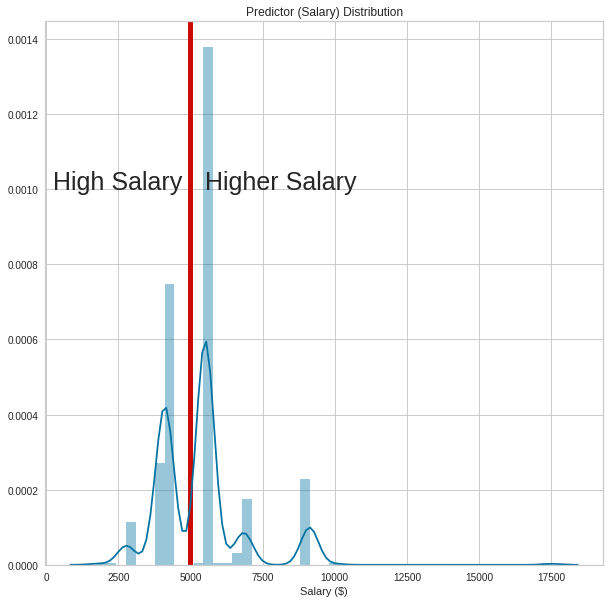

In [655]:
fig, ax = plt.subplots(figsize = (10, 10))
plt.title('Predictor (Salary) Distribution')
plt.xlabel('Salary ($)')
ax.axvline(5000, color = 'r', linewidth = 5)
sns.distplot(price_sr, ax = ax)
plt.text(250, 0.001, 'High Salary', fontsize = 25)
plt.text(5500, 0.001, 'Higher Salary', fontsize = 25)

## Classification problem
### Since this distribution of the wages are bimodal, this should be classified as a classification problem

In [531]:
y = (y > 5000).astype(int)

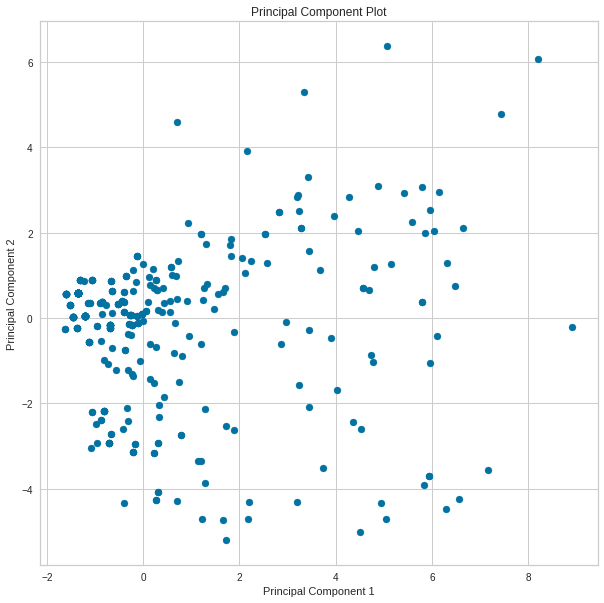

In [97]:
from yellowbrick.features.pca import PCADecomposition

plt.figure(figsize = (10, 10))
visualizer = PCADecomposition(scale = True, center = False, col = y)
visualizer.fit_transform(features_numeric, y)
visualizer.poof()

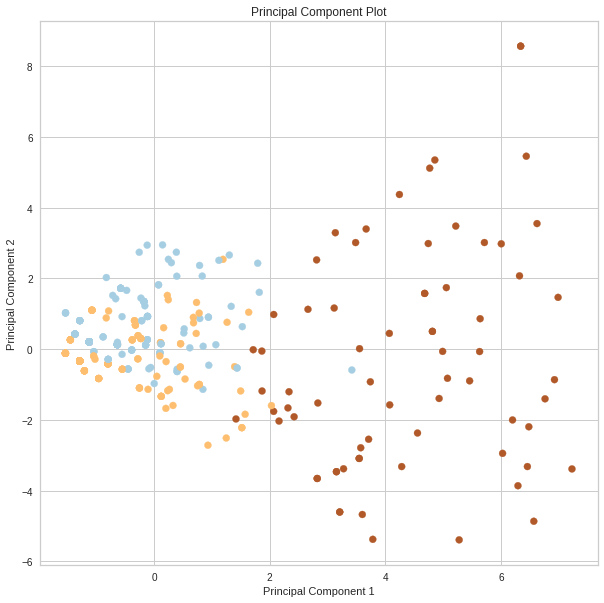

In [530]:
from sklearn.cluster import KMeans

cluster = 3
kmeans = KMeans(n_clusters = cluster, n_jobs = -1).fit(X)
plt.figure(figsize = (10, 10))
visualizer = PCADecomposition(scale = True, center = False, col = y, color = kmeans.labels_, \
                              colormap = 'Paired')
visualizer.fit_transform(features_numeric, y)
visualizer.poof()

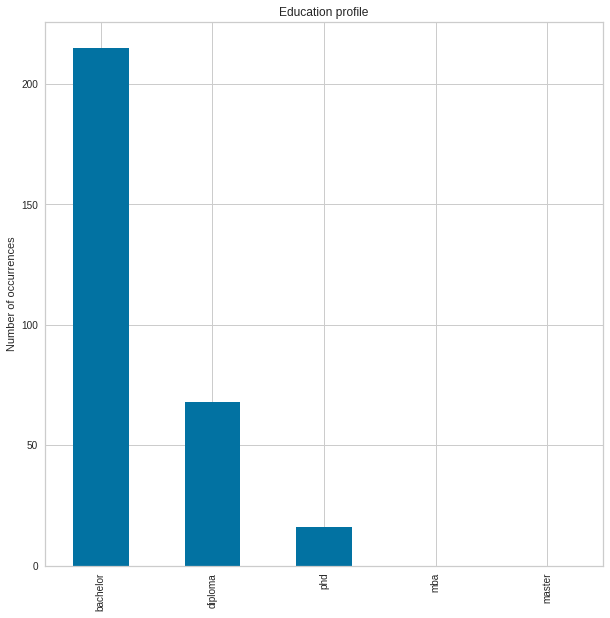

In [657]:
total_edu = p_edu.fit_transform(data_scientist_df).sum(axis = 0)

top_edu = total_edu.sort_values(axis = 0, ascending = False)

top_edu.plot(kind = 'bar', figsize = (10, 10))
plt.title('Education profile')
plt.ylabel('Number of occurrences')

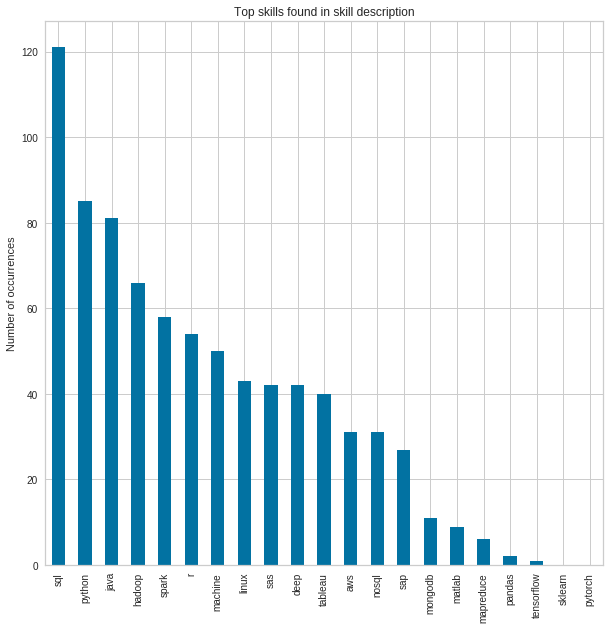

In [129]:
total_skills = p_skill.fit_transform(data_scientist_df).sum(axis = 0)

top_skills = total_skills.sort_values(axis = 0, ascending = False)

top_skills.plot(kind = 'bar', figsize = (10, 10))
plt.title('Top skills found in skill description')
plt.ylabel('Number of occurrences')

## The top 20 most common words found in skills descriptions

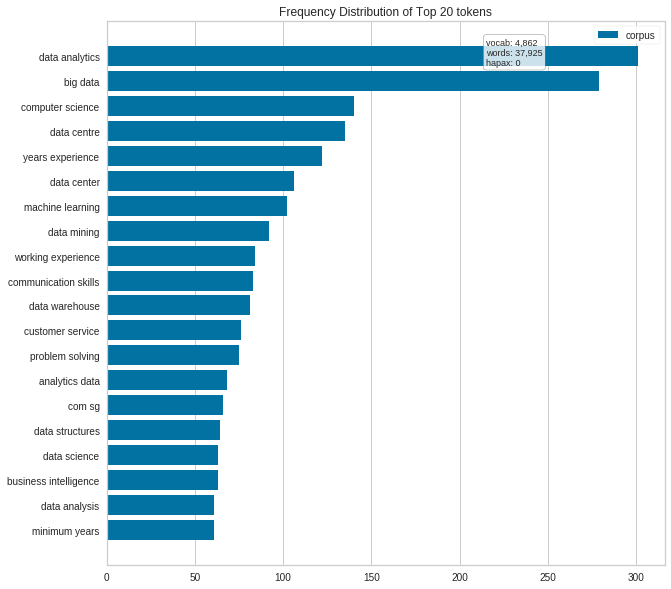

In [118]:
from yellowbrick.text.freqdist import FreqDistVisualizer

cvt = CountVectorizer(stop_words = 'english', ngram_range = range(2, 4), min_df = 4)
doc = cvt.fit_transform(data_scientist_df['skillset'])
features = cvt.get_feature_names()

plt.figure(figsize = (10, 10))
visualizer = FreqDistVisualizer(features = features, n= 20)
visualizer.fit(doc)
visualizer.poof()

### TSNE of skillsets
#### Not that useful without topics

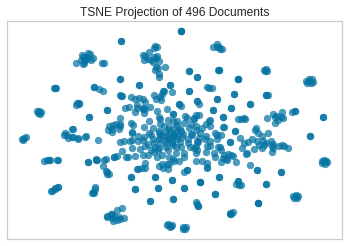

In [120]:
from yellowbrick.text import TSNEVisualizer

tfidf = TfidfVectorizer(stop_words = 'english', ngram_range = range(2, 4))
docs = tfidf.fit_transform(data_scientist_df['skillset'])

tsne = TSNEVisualizer()
tsne.fit(docs)
tsne.poof()

## Top 20 most common words found in job titles

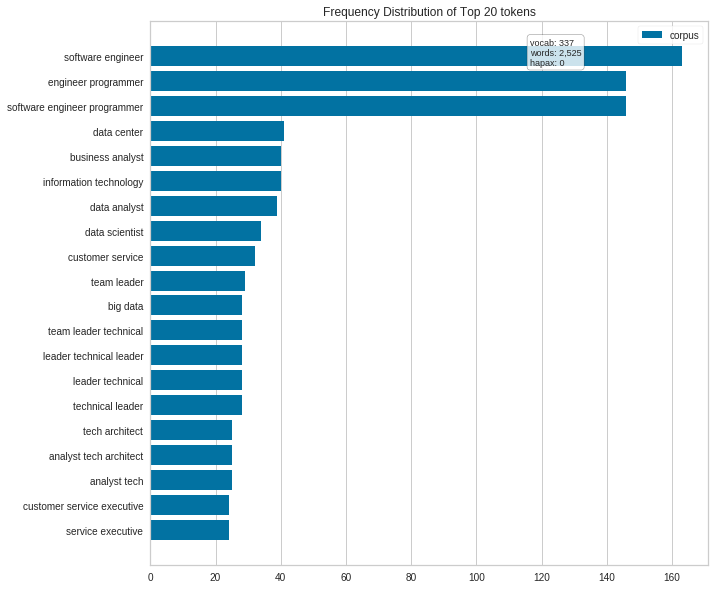

In [125]:
cvt = CountVectorizer(stop_words = 'english', ngram_range = range(2, 4), min_df = 3)
doc = cvt.fit_transform(data_scientist_df['Title'])
features = cvt.get_feature_names()

plt.figure(figsize = (10, 10))
visualizer = FreqDistVisualizer(features = features, n= 20)
visualizer.fit(doc)
visualizer.poof()

## Nationality

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), <a list of 10 Text xticklabel objects>)

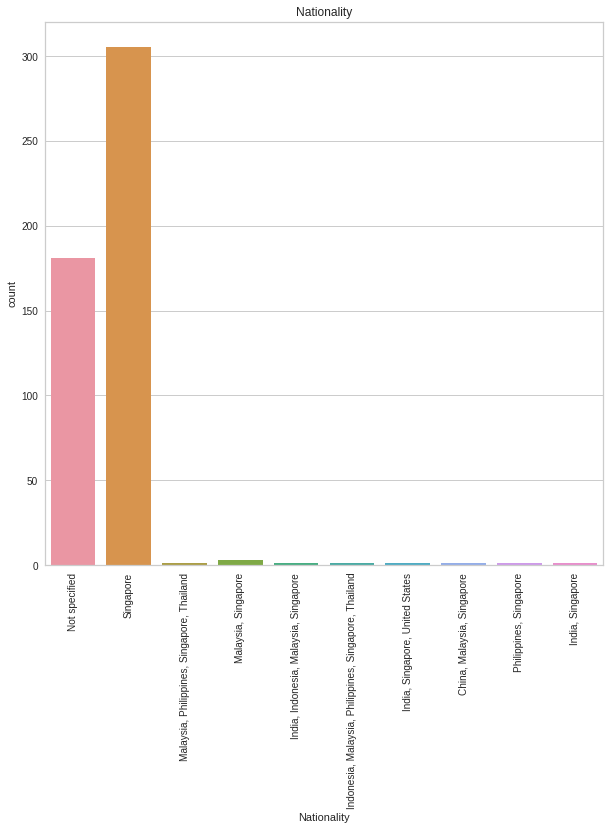

In [121]:
plt.figure(figsize = (10, 10))
sns.countplot(data_scientist_df.Nationality.replace('', 'Not specified'))
plt.title('Nationality')
plt.xticks(rotation = 90)

## Industry

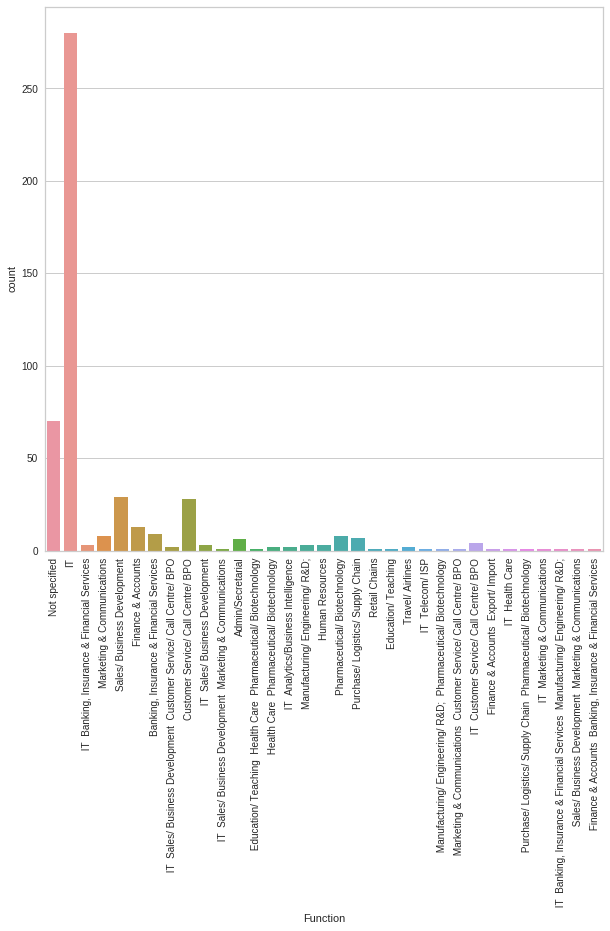

In [141]:
plt.figure(figsize = (10, 10))
sns.countplot(data_scientist_df.Function.replace('', 'Not specified').str.replace(r'•', ''))
plt.xticks(rotation = 90)
plt.show()

## Geographical information of company and its job title

In [123]:
import googlemaps

gmaps = googlemaps.Client(key = GMAP_API_KEY)

lat, lon = [], []

for company in data_scientist_df['Company']:
    try:
        lat.append(gmaps.geocode(company + ' ,Singapore')[0]['geometry']['location']['lat'])
        lon.append(gmaps.geocode(company + ' ,Singapore')[0]['geometry']['location']['lng'])
    except:
        lat.append(1.3521)
        lon.append(103.8198)
    
data_scientist_df['lat'] = lat
data_scientist_df['lon'] = lon

In [124]:
from bokeh.io import output_file, show
from bokeh.models import (GMapPlot, GMapOptions, ColumnDataSource, Circle, \
                          DataRange1d, PanTool, WheelZoomTool, BoxSelectTool, HoverTool)

map_options = GMapOptions(lat=1.3521, lng=103.8198, map_type="roadmap", zoom=11)

plot = GMapPlot(x_range=DataRange1d(), y_range=DataRange1d(), map_options=map_options)

plot.title.text = "Singapore"

plot.api_key = GMAP_API_KEY

source = ColumnDataSource(data_scientist_df)

circle = Circle(x="lon", y="lat", size=15, fill_color="blue", fill_alpha=0.8, line_color=None)
plot.add_glyph(source, circle)

plot.add_tools(PanTool(), WheelZoomTool(), BoxSelectTool())
plot.add_tools( HoverTool(tooltips= [("Company","@Company"),
                                    ("Job Title","@Title")]))

output_file("gmap_plot.html")
show(plot)

### Feature Selection : Filtering

#### Looking at Shapiro Ranking (rank of normality) and Correlation

### Feature Selection : Wrapper

#### Wrapper not done -> Too little rows for wrapper feature selection to work

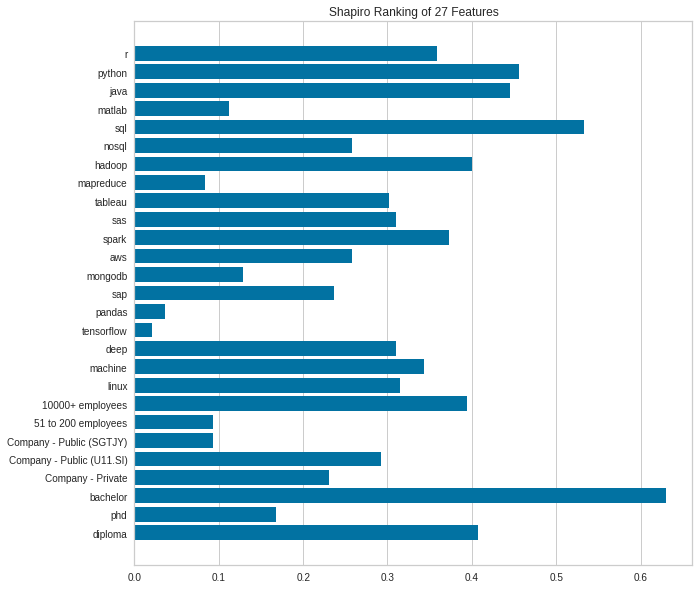

In [142]:
from yellowbrick.features.rankd import Rank1D, Rank2D

plt.figure(figsize = (10, 10))
visualizer = Rank1D(features = feature_names, algorithm = 'shapiro')
visualizer.fit_transform(features_numeric)
visualizer.poof()

### Drop SAP, PANDAS and Mapreduce since it has low Shapiro ranking

In [143]:
features_numeric.drop(['tensorflow', 'pandas', 'mapreduce'], axis = 1, inplace = True)

## Correlation Heatmap

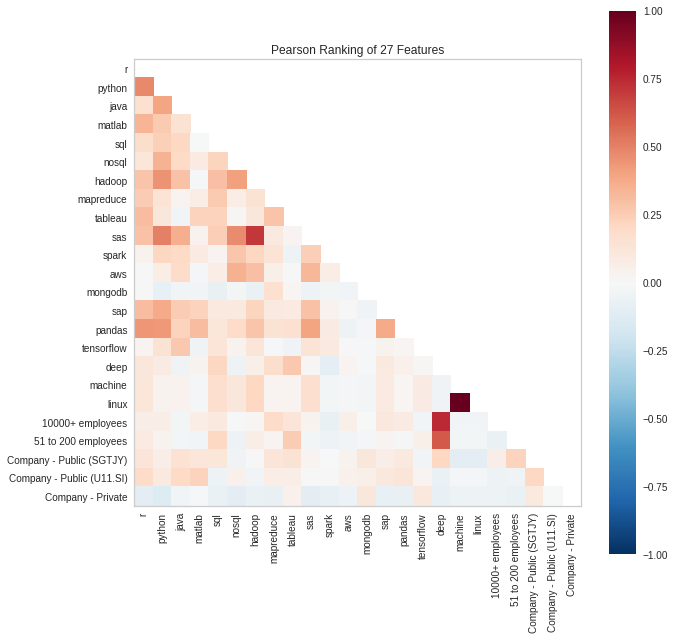

In [144]:
plt.figure(figsize = (10, 10))
visualizer = Rank2D(features = feature_names, algorithm = 'pearson')
visualizer.fit_transform(features_numeric)
visualizer.poof()

### Variance Inflation Factor

/home/ljiahest/anaconda2/lib/python2.7/site-packages/statsmodels/stats/outliers_influence.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


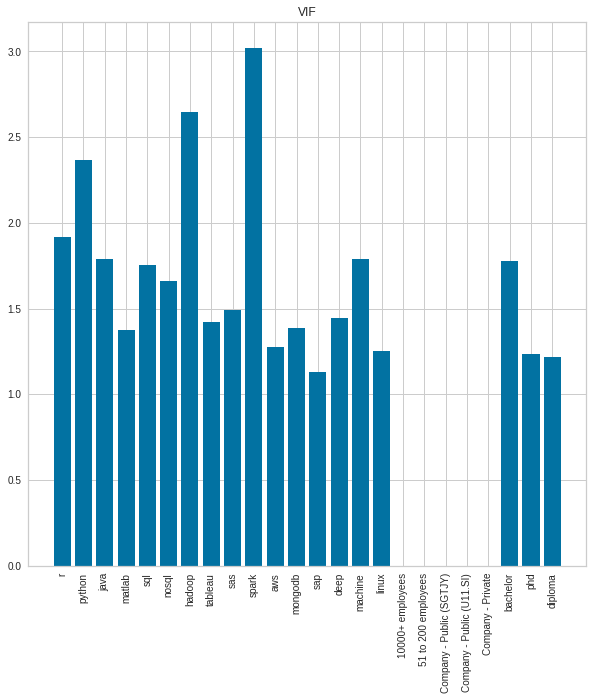

In [145]:
from statsmodels.stats.outliers_influence import variance_inflation_factor as VIF

vif = pd.Series([VIF(features_numeric.values, i) for i in range(features_numeric.shape[1])])

plt.figure(figsize = (10, 10))
plt.bar(range(len(vif)), vif)
plt.title('VIF')
plt.xticks(range(features_numeric.shape[1]), features_numeric.columns, rotation = 90)
plt.show()

In [146]:
# Drop infinity values
col_drop = vif.values != np.inf
features_numeric = features_numeric.loc[:, col_drop]

### Train Test Split

In [149]:
text = p_tfidf.fit_transform(data_scientist_df)

X = np.c_[features_numeric.values, text.toarray()]

In [161]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0, test_size = 0.2)

### Logistic Regression Regularization

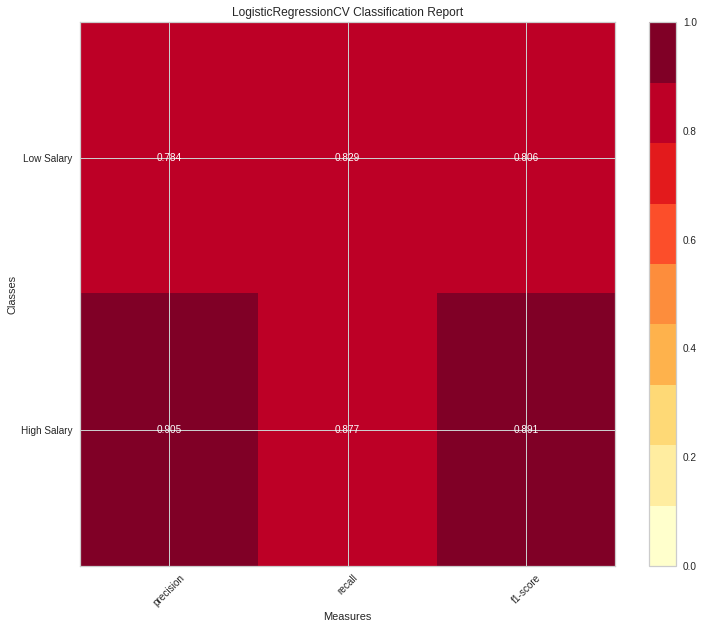

In [183]:
from sklearn.linear_model import LogisticRegressionCV
from yellowbrick.classifier import ClassificationReport, ROCAUC, ClassBalance
from yellowbrick.classifier import ConfusionMatrix

# Fit Logistic Regression
logreg = LogisticRegressionCV(n_jobs = -1)
logreg.fit(X_train, y_train)

# Legend
classes = ['Low Salary', 'High Salary']

# Plot Classification ReportRegression
plt.figure(figsize = (12, 10))
visualizer = ClassificationReport(logreg, classes = classes)
visualizer.fit(X_train, y_train)  
visualizer.score(X_test, y_test)
visualizer.poof()
plt.show()

### Adaboost Classification

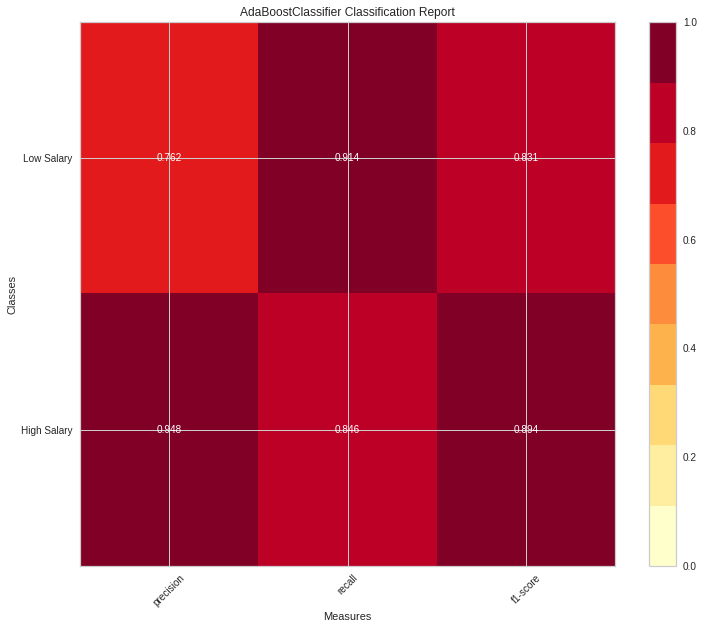

In [182]:
from sklearn.ensemble import AdaBoostClassifier

adaboost = AdaBoostClassifier()
adaboost.fit(X_train, y_train)

# Plot Classification ReportRegression
plt.figure(figsize = (12, 10))
visualizer = ClassificationReport(adaboost, classes = classes)
visualizer.fit(X_train, y_train)  
visualizer.score(X_test, y_test)
visualizer.poof()
plt.show()

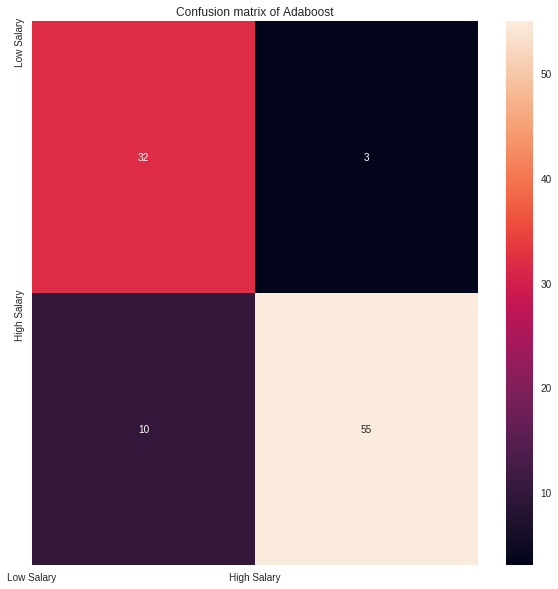

In [180]:
from sklearn.metrics import confusion_matrix

plt.figure(figsize = (10, 10))
y_pred = adaboost.predict(X_test)
sns.heatmap(confusion_matrix(y_test, y_pred), annot = True)
plt.xticks([0, 1], classes)
plt.yticks([0, 1], classes, rotation = 90)
plt.title('Confusion matrix of Adaboost')
plt.show()

## Features without Text

This is to capture all the skills required of the worker, instead of the content of the job listing

In [230]:
X_train, X_test, y_train, y_test = train_test_split(features_numeric.values, y, \
                                                    random_state = 0, test_size = 0.2)

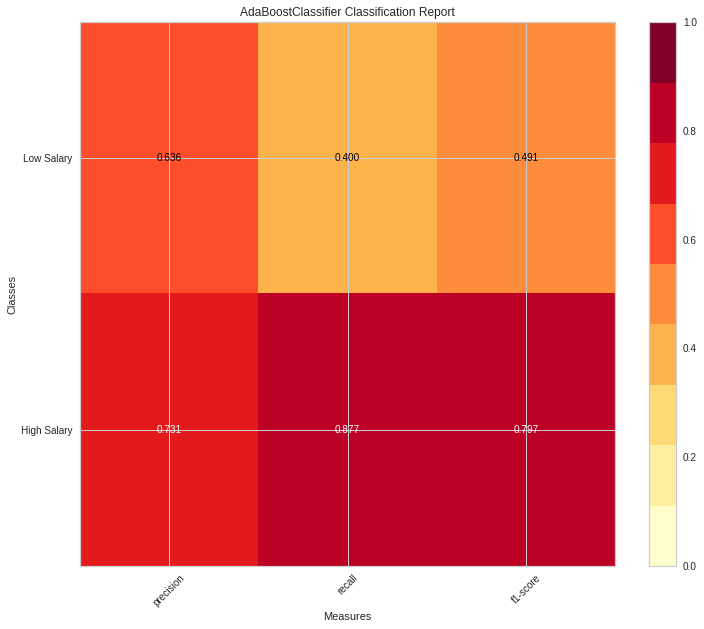

In [231]:
adaboost = AdaBoostClassifier()
adaboost.fit(X_train, y_train)

# Plot Classification ReportRegression
plt.figure(figsize = (12, 10))
visualizer = ClassificationReport(adaboost, classes = classes)
visualizer.fit(X_train, y_train)  
visualizer.score(X_test, y_test)
visualizer.poof()
plt.show()

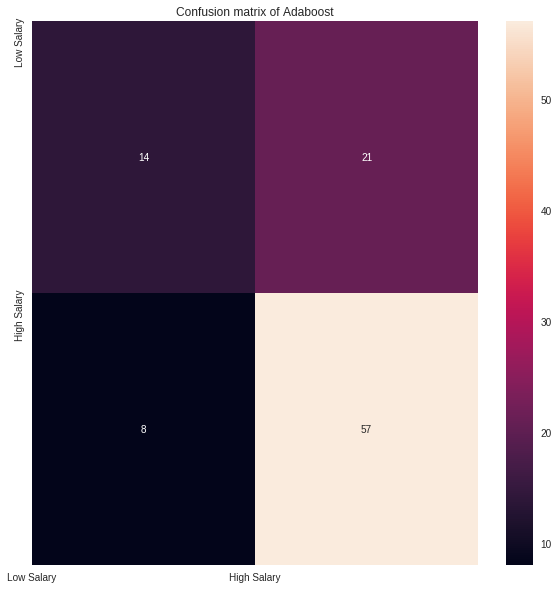

In [232]:
plt.figure(figsize = (10, 10))
y_pred = adaboost.predict(X_test)
sns.heatmap(confusion_matrix(y_test, y_pred), annot = True)
plt.xticks([0, 1], classes)
plt.yticks([0, 1], classes, rotation = 90)
plt.title('Confusion matrix of Adaboost')
plt.show()

## Question 2 - Senior vs Junior

In [235]:
pattern = re.compile(SENIOR, flags=re.IGNORECASE)

y = data_scientist_df['Title'].str.lower().str.contains(pattern).astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0, test_size = 0.2)

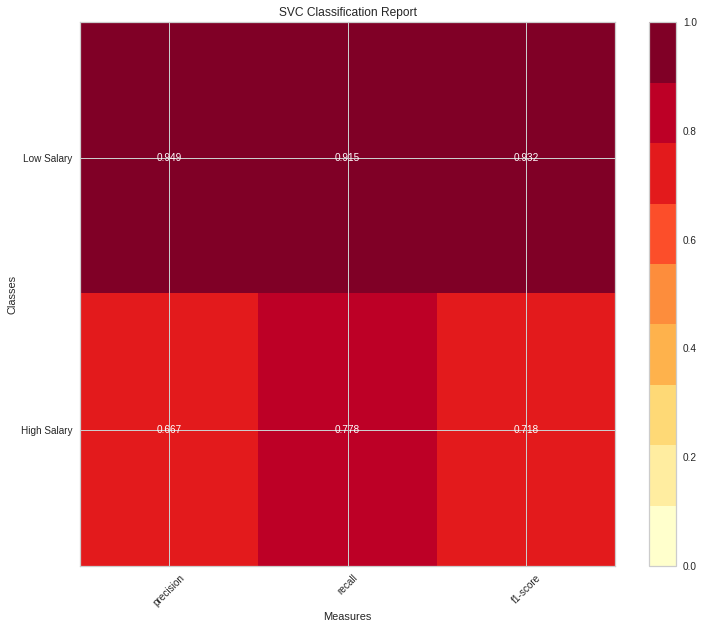

In [254]:
from sklearn.svm import SVC

classes = ['Junior', 'Senior']

true_class = y.sum()/len(y)
class_weight = {0: true_class, 1: (1 - true_class)}

svc = SVC(kernel = 'linear', class_weight = class_weight)
svc.fit(X_train, y_train)

# Plot Classification ReportRegression
plt.figure(figsize = (12, 10))
visualizer = ClassificationReport(svc, classes = classes)
visualizer.fit(X_train, y_train)  
visualizer.score(X_test, y_test)
visualizer.poof()
plt.show()

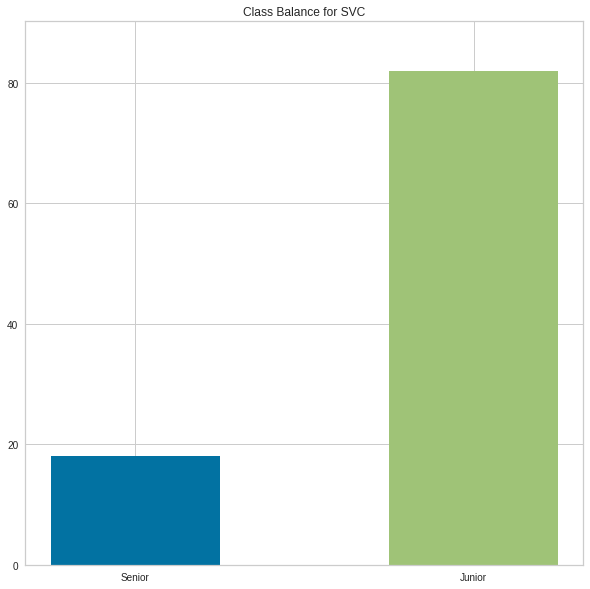

In [258]:
from yellowbrick.classifier import ClassBalance

classes = ['Junior', 'Senior']

plt.figure(figsize = (10, 10))

visualizer = ClassBalance(svc, classes=classes)

visualizer.fit(X_train, y_train) 
visualizer.score(X_test, y_test)
g = visualizer.poof() 

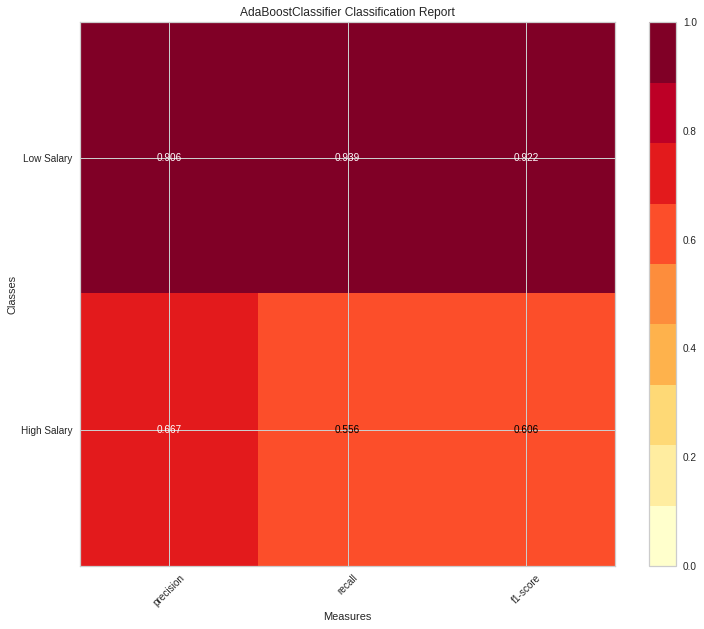

In [236]:
adaboost = AdaBoostClassifier()
adaboost.fit(X_train, y_train)

# Plot Classification ReportRegression
plt.figure(figsize = (12, 10))
visualizer = ClassificationReport(adaboost, classes = classes)
visualizer.fit(X_train, y_train)  
visualizer.score(X_test, y_test)
visualizer.poof()a
plt.show()

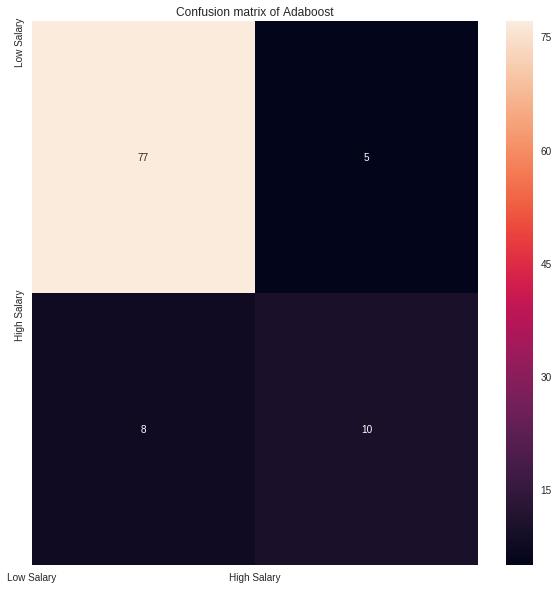

In [237]:
plt.figure(figsize = (10, 10))
y_pred = adaboost.predict(X_test)
sns.heatmap(confusion_matrix(y_test, y_pred), annot = True)
plt.xticks([0, 1], classes)
plt.yticks([0, 1], classes, rotation = 90)
plt.title('Confusion matrix of Adaboost')
plt.show()

## Load Glove dictionary

In [317]:
import os

embeddings_index = {}
f = open(os.path.join('./glove.6B', 'glove.6B.100d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

## Tokenize each word

In [338]:
MAX_SEQUENCE_LENGTH = 1000
MAX_NB_WORDS = 10000
EMBEDDING_DIM = 100

In [ ]:
# Validation
val_size = int(0.2 * data.shape[0])

# Randomize indices
indices = np.arange(data.shape[0])
np.random.shuffle(indices)

# Randomize data and y
data = data[indices]
y_shuffled = y[indices]

# Train-test data and y
X_train, X_test = data[ :-val_size], data[-val_size: ]
y_train, y_test = y_shuffled[ :-val_size], y_shuffled[-val_size: ]

In [545]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

texts = data_scientist_df['skillset']

tokenizer = Tokenizer(num_words = MAX_NB_WORDS)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
word_index = tokenizer.word_index

data = pad_sequences(sequences, maxlen = MAX_SEQUENCE_LENGTH)

In [633]:
from keras.layers import Dense, Flatten, concatenate, Dropout, BatchNormalization
from keras.layers import Conv1D, MaxPooling1D, Embedding, GlobalMaxPooling1D
from keras.models import Model
from keras.layers import Input

In [546]:
# Minimize number of words to either length of word tokens or max word count
num_words = min(MAX_NB_WORDS, len(word_index))

# Creaete Word2Vec dictionary of zeros
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))

for word, i in word_index.items():
    if i >= MAX_NB_WORDS:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

## Text Embedding
Embedded text into a lookup table

In [608]:
# Input layer
text_input = Input(shape = (MAX_SEQUENCE_LENGTH, ))

# Embedding layer
text_embed = Embedding(num_words, EMBEDDING_DIM, weights=[embedding_matrix], \
                       input_length = MAX_SEQUENCE_LENGTH, trainable=False)(text_input)

# First Convolution 1D layer
x = Conv1D(filters = 128, kernel_size = 5, activation = 'relu')(text_embed)

# First MaxPooling to reduce 
x = MaxPooling1D(pool_size = 5)(x)

# Second Convolution 1D layer
x = Conv1D(filters = 128, kernel_size = 5, activation = 'relu')(x)

# Second MaxPooling 
x = MaxPooling1D(pool_size = 5)(x)

# Global MaxPooling to reduce dimensions
x = GlobalMaxPooling1D()(x)

# Dense to first layer
x = Dense(units = 64, activation = 'relu')(x)

# Dense to output
pred = Dense(units = 1, activation = 'sigmoid')(x)

<tf.Tensor 'dense_28/Sigmoid:0' shape=(?, 1) dtype=float32>

In [618]:
# Model
model = Model(inputs = text_input, outputs = pred)

# Compile model for classification
model.compile(loss = 'binary_crossentropy', optimizer = 'rmsprop', metrics = ['accuracy'])

# Fit model
model.fit(x = X_train, y = y_train, batch_size = 2, epochs = 10, \
          validation_data = (X_test, y_test), shuffle = False)

Train on 397 samples, validate on 99 samples
Epoch 1/10
397/397 [==============================] - 6s - loss: 0.6981 - acc: 0.5844 - val_loss: 0.6742 - val_acc: 0.6061
Epoch 2/10
397/397 [==============================] - 5s - loss: 0.6483 - acc: 0.6071 - val_loss: 0.7241 - val_acc: 0.4848
Epoch 3/10
397/397 [==============================] - 5s - loss: 0.5465 - acc: 0.7204 - val_loss: 0.9065 - val_acc: 0.4848
Epoch 4/10
397/397 [==============================] - 5s - loss: 0.4018 - acc: 0.8237 - val_loss: 1.2285 - val_acc: 0.4646
Epoch 5/10
397/397 [==============================] - 6s - loss: 0.2829 - acc: 0.8967 - val_loss: 1.3393 - val_acc: 0.5152
Epoch 6/10
397/397 [==============================] - 6s - loss: 0.2053 - acc: 0.9370 - val_loss: 1.5005 - val_acc: 0.5152
Epoch 7/10
397/397 [==============================] - 7s - loss: 0.1779 - acc: 0.9521 - val_loss: 1.8859 - val_acc: 0.5657
Epoch 8/10
397/397 [==============================] - 6s - loss: 0.1677 - acc: 0.9547 - val_lo

## Skills Embedding

Embedded into a lookup table

In [539]:
skills_data = p_skill.fit_transform(data_scientist_df).values

skill_input = Input(shape = (skills_data.shape[1], ))
skill_embed = Embedding(10, 1, input_length = skills_data.shape[1], trainable = True)(skill_input)
skill_embed = Flatten()(skill_embed)

## Education Embedding
Embedded into a lookup table

In [540]:
edu_data = p_edu.fit_transform(data_scientist_df).values

edu_input = Input(shape = (edu_data.shape[1], ))
edu_embed = Embedding(2, 1, input_length = edu_data.shape[1], trainable = True)(edu_input)
edu_embed = Flatten()(edu_embed)

## Experience Embedding
Embedded into a lookup table

In [541]:
exp_data = p_exp.fit_transform(data_scientist_df)

exp_input = Input(shape = (exp_data.shape[1], ))
exp_embed = Dense(1, kernel_initializer = 'normal')(exp_input)

# Building NN layers without Text

In [641]:
# Concatentate all the layers without Text
x = concatenate([exp_embed, skill_embed, edu_embed], axis = 1)

# Dense
x = Dense(20, activation = 'relu')(x) 

# Dropout of 0.4
x = Dropout(0.4)(x)

# Dense
x = Dense(10, activation = 'relu')(x)

pred = Dense(1, activation = 'sigmoid')(x)

### Train-test split Experience, Skills and Education columns

In [643]:
model = Model(inputs = [exp_input, skill_input, edu_input], outputs = pred)

model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

model.fit(x = [exp_train, skill_train, edu_train], y = y_train, epochs = 10, batch_size = 2, \
          validation_data = ([exp_test, skill_test, edu_test], y_test))

Train on 396 samples, validate on 100 samples
Epoch 1/10
396/396 [==============================] - 0s - loss: 0.6537 - acc: 0.6667 - val_loss: 0.6519 - val_acc: 0.6700
Epoch 2/10
396/396 [==============================] - 0s - loss: 0.6427 - acc: 0.6540 - val_loss: 0.6458 - val_acc: 0.6700
Epoch 3/10
396/396 [==============================] - 0s - loss: 0.6345 - acc: 0.6490 - val_loss: 0.6395 - val_acc: 0.6700
Epoch 4/10
396/396 [==============================] - 0s - loss: 0.6208 - acc: 0.6843 - val_loss: 0.6331 - val_acc: 0.6900
Epoch 5/10
396/396 [==============================] - 0s - loss: 0.6235 - acc: 0.6818 - val_loss: 0.6338 - val_acc: 0.6900
Epoch 6/10
396/396 [==============================] - 0s - loss: 0.6227 - acc: 0.6591 - val_loss: 0.6366 - val_acc: 0.6800
Epoch 7/10
396/396 [==============================] - 0s - loss: 0.6076 - acc: 0.7020 - val_loss: 0.6297 - val_acc: 0.6800
Epoch 8/10
396/396 [==============================] - 0s - loss: 0.6109 - acc: 0.6768 - val_l

# Building NN layers with Text

In [635]:
exp_train, exp_test, skill_train, skill_test, edu_train, edu_test, tx_train, tx_test, y_train, y_test = \
train_test_split(exp_data, skills_data, edu_data, data, y, random_state = 0, test_size = 0.2)

In [644]:
# Concatenate all the columns
x = concatenate([exp_embed, skill_embed, edu_embed, pred], axis = 1)

# Dense
x = Dense(20, activation = 'relu')(x)

# Dense
x = Dense(4, activation = 'relu')(x)

pred = Dense(1, activation = 'sigmoid')(x)

In [645]:
model = Model(inputs = [exp_input, skill_input, edu_input, text_input], outputs = pred)

model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

model.fit(x = [exp_train, skill_train, edu_train, tx_train], y = y_train, epochs = 10, batch_size = 2, \
          validation_data = ([exp_test, skill_test, edu_test, tx_test], y_test))

Train on 396 samples, validate on 100 samples
Epoch 1/10
396/396 [==============================] - 0s - loss: 0.6648 - acc: 0.6641 - val_loss: 0.6200 - val_acc: 0.6700
Epoch 2/10
396/396 [==============================] - 0s - loss: 0.6146 - acc: 0.6894 - val_loss: 0.6031 - val_acc: 0.6600
Epoch 3/10
396/396 [==============================] - 0s - loss: 0.5919 - acc: 0.7020 - val_loss: 0.6016 - val_acc: 0.6600
Epoch 4/10
396/396 [==============================] - 0s - loss: 0.5758 - acc: 0.7020 - val_loss: 0.5919 - val_acc: 0.6700
Epoch 5/10
396/396 [==============================] - 0s - loss: 0.5638 - acc: 0.7146 - val_loss: 0.5996 - val_acc: 0.6500
Epoch 6/10
396/396 [==============================] - 0s - loss: 0.5544 - acc: 0.7172 - val_loss: 0.6041 - val_acc: 0.6500
Epoch 7/10
396/396 [==============================] - 0s - loss: 0.5408 - acc: 0.7172 - val_loss: 0.6056 - val_acc: 0.6600
Epoch 8/10
396/396 [==============================] - 0s - loss: 0.5363 - acc: 0.7273 - val_l